## Introduction

This example implements three modern attention-free, multi-layer perceptron (MLP) based models for image
classification, demonstrated on the CIFAR-100 dataset:

1. The [MLP-Mixer](https://arxiv.org/abs/2105.01601) model, by Ilya Tolstikhin et al., based on two types of MLPs.
3. The [FNet](https://arxiv.org/abs/2105.03824) model, by James Lee-Thorp et al., based on unparameterized
Fourier Transform.
2. The [gMLP](https://arxiv.org/abs/2105.08050) model, by Hanxiao Liu et al., based on MLP with gating.

The purpose of the example is not to compare between these models, as they might perform differently on
different datasets with well-tuned hyperparameters. Rather, it is to show simple implementations of their
main building blocks.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```shell
pip install -U tensorflow-addons
```

## Setup

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/LAU/Fall-2022/IEA/Projects/Project 1/csv_ensemble2/csv_ensemble2/class1_model2.csv')


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_classes = 62
input_shape = (25, 25, 1)

train_data, test_data = train_test_split(data, test_size=0.25, random_state=1, shuffle=True)

# Split datasets into features and labels
x_train = train_data.drop('0', axis=1).to_numpy()
x_test = test_data.drop('0', axis=1).to_numpy()
y_train = train_data['0'].to_numpy()
y_test = test_data['0'].to_numpy()

print("Before Slicing")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Select 625 columns of every row to have input shape (25,25,1)
x_train = x_train[:,:625]
x_test = x_test[:,:625]


#Feature Scaling
scaler = MinMaxScaler()
x_train =scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(f"After Slicing")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Before Slicing
x_train shape: (195, 666) - y_train shape: (195,)
x_test shape: (65, 666) - y_test shape: (65,)
After Slicing
x_train shape: (195, 625) - y_train shape: (195,)
x_test shape: (65, 625) - y_test shape: (65,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
x_train = x_train.reshape([x_train.shape[0],25,25,1]).astype(float)
x_test = x_test.reshape([x_test.shape[0],25,25,1]).astype(float)

## Configure the hyperparameters

In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 25  # We'll resize input images to this size.
patch_size = 5  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 25 X 25 = 625
Patch size: 5 X 5 = 25 
Patches per image: 25
Elements per patch (3 channels): 75


## Build a classification model

We implement a method that builds a classifier given the processing blocks.

In [ ]:

def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

We implement a utility function to compile, train, and evaluate a given model.

In [ ]:

def run_experiment(model):

    # Compile the model.
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    model.save('/content/drive/MyDrive/LAU/Fall-2022/IEA/Projects/Project 1/Model/class1-model2-gmlp')

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches


## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [ ]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


### Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [ ]:
import matplotlib.pyplot as plt

mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)


Epoch 1/50
2/2 [==============================] - 5s 850ms/step - loss: 7.9674 - acc: 0.2171 - top5-acc: 0.7943 - val_loss: 2.9380 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 0s 79ms/step - loss: 3.8465 - acc: 0.1257 - top5-acc: 0.7943 - val_loss: 2.6253 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 0s 65ms/step - loss: 3.4134 - acc: 0.1200 - top5-acc: 0.7943 - val_loss: 2.8115 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 0s 76ms/step - loss: 3.3539 - acc: 0.1657 - top5-acc: 0.7943 - val_loss: 1.9300 - val_acc: 0.3000 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 0s 105ms/step - loss: 2.7457 - acc: 0.1829 - top5-acc: 0.7943 - val_loss: 1.6641 - val_acc: 0.2500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 69ms/step - loss: 2.3554 

3/3 [==============================] - 0s 12ms/step - loss: 1.4532 - acc: 0.2923 - top5-acc: 1.0000
Test accuracy: 29.23%
Test top 5 accuracy: 100.0%


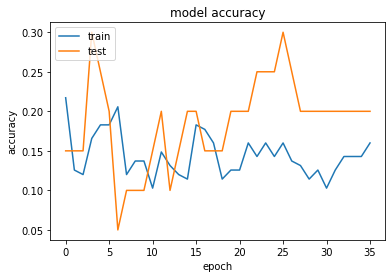

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The MLP-Mixer model tends to have much less number of parameters compared
to convolutional and transformer-based models, which leads to less training and
serving computational cost.

As mentioned in the [MLP-Mixer](https://arxiv.org/abs/2105.01601) paper,
when pre-trained on large datasets, or with modern regularization schemes,
the MLP-Mixer attains competitive scores to state-of-the-art models.
You can obtain better results by increasing the embedding dimensions,
increasing the number of mixer blocks, and training the model for longer.
You may also try to increase the size of the input images and use different patch sizes.

## The FNet model

The FNet uses a similar block to the Transformer block. However, FNet replaces the self-attention layer
in the Transformer block with a parameter-free 2D Fourier transformation layer:

1. One 1D Fourier Transform is applied along the patches.
2. One 1D Fourier Transform is applied along the channels.

### Implement the FNet module

In [ ]:

class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)


### Build, train, and evaluate the FNet model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [ ]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

Epoch 1/50
2/2 [==============================] - 4s 597ms/step - loss: 9.0310 - acc: 0.1714 - top5-acc: 0.7943 - val_loss: 2.6952 - val_acc: 0.2000 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 0s 79ms/step - loss: 3.2916 - acc: 0.1714 - top5-acc: 0.7943 - val_loss: 2.4558 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 0s 74ms/step - loss: 3.1934 - acc: 0.0914 - top5-acc: 0.7943 - val_loss: 2.3178 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 0s 87ms/step - loss: 3.0138 - acc: 0.1143 - top5-acc: 0.7943 - val_loss: 1.7868 - val_acc: 0.0500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 0s 72ms/step - loss: 2.4658 - acc: 0.1429 - top5-acc: 0.7943 - val_loss: 1.8849 - val_acc: 0.2500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 65ms/step - loss: 2.4201 -

3/3 [==============================] - 0s 11ms/step - loss: 2.3229 - acc: 0.1231 - top5-acc: 1.0000
Test accuracy: 12.31%
Test top 5 accuracy: 100.0%


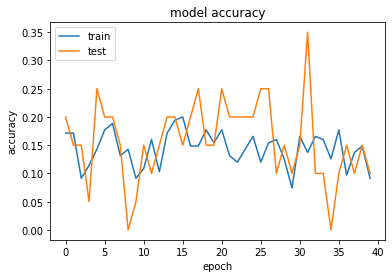

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As shown in the [FNet](https://arxiv.org/abs/2105.03824) paper,
better results can be achieved by increasing the embedding dimensions,
increasing the number of FNet blocks, and training the model for longer.
You may also try to increase the size of the input images and use different patch sizes.
The FNet scales very efficiently to long inputs, runs much faster than attention-based
Transformer models, and produces competitive accuracy results.

## The gMLP model

The gMLP is a MLP architecture that features a Spatial Gating Unit (SGU).
The SGU enables cross-patch interactions across the spatial (channel) dimension, by:

1. Transforming the input spatially by applying linear projection across patches (along channels).
2. Applying element-wise multiplication of the input and its spatial transformation.

### Implement the gMLP module

In [ ]:

class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected


### Build, train, and evaluate the gMLP model

Note that training the model with the current settings on a V100 GPUs
takes around 9 seconds per epoch.

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/50
2/2 [==============================] - 4s 754ms/step - loss: 10.3162 - acc: 0.1029 - top5-acc: 0.7943 - val_loss: 3.9977 - val_acc: 0.1500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 0s 77ms/step - loss: 4.6182 - acc: 0.0971 - top5-acc: 0.7943 - val_loss: 3.3129 - val_acc: 0.2000 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 0s 77ms/step - loss: 3.4240 - acc: 0.2114 - top5-acc: 0.7943 - val_loss: 1.4775 - val_acc: 0.3500 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 0s 66ms/step - loss: 2.1336 - acc: 0.1829 - top5-acc: 0.7943 - val_loss: 2.1993 - val_acc: 0.2000 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 0s 68ms/step - loss: 2.7102 - acc: 0.1657 - top5-acc: 0.7943 - val_loss: 2.2928 - val_acc: 0.3000 - val_top5-acc: 0.8500 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 66ms/step - loss: 2.6282 

3/3 [==============================] - 0s 10ms/step - loss: 1.8636 - acc: 0.2000 - top5-acc: 1.0000
Test accuracy: 20.0%
Test top 5 accuracy: 100.0%


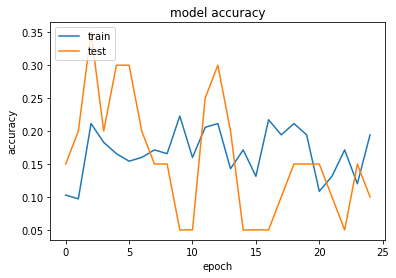

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As shown in the [gMLP](https://arxiv.org/abs/2105.08050) paper,
better results can be achieved by increasing the embedding dimensions,
increasing, increasing the number of gMLP blocks, and training the model for longer.
You may also try to increase the size of the input images and use different patch sizes.
Note that, the paper used advanced regularization strategies, such as MixUp and CutMix,
as well as AutoAugment.